This program shows how to derive **feature importance** from a **Random Forest regression** model.

In [ ]:
pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.7-cp37-none-any.whl size=10670 sha256=c1815a5a067352dfb1f7630ed81c1a4686a65041723a3edb6f363a4f9a20e587
  Stored in directory: /root/.cache/pip/wheels/16/08/23/9d90df482c9c943df4d6fe874c0937f8e81dc3db917c9300c2
Successfully built rfpimp


In [ ]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
boston = load_boston()
y = boston.target
X = pd.DataFrame(boston.data, columns = boston.feature_names)
np.random.seed(seed = 42)
X['random'] = np.random.random(size = len(X))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.8, random_state = 42)

As for out-of-bag error, each tree in the Random Forest is trained on a different dataset, sampled with replacement from the original data. This results in around ~2/3 of distinct observations in each training set. The out-of-bag error is calculated on all the observations, but for calculating each row’s error the model only considers trees that have not seen this row during training. This is similar to evaluating the model on a validation set. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))


R^2 Training Score: 0.93 
OOB Score: 0.58 
R^2 Validation Score: 0.76


In [ ]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
print(perm_imp_rfpimp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


         Importance
Feature            
LSTAT      0.445872
RM         0.436355
DIS        0.066912
CRIM       0.042532
TAX        0.020114
NOX        0.017309
AGE        0.015293
PTRATIO    0.014781
B          0.009048
random     0.008060
INDUS      0.003139
RAD        0.003039
CHAS       0.001041
ZN         0.000948


In [ ]:
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

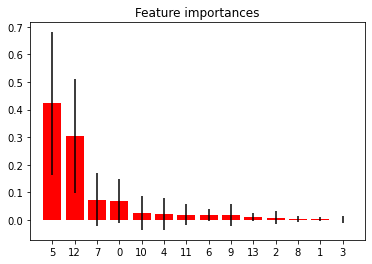

In [ ]:
# Plot the impurity-based feature importances of the forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

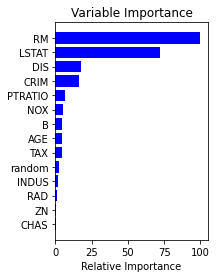

In [ ]:
# Plot the impurity-based feature importances of the forest
feature_importance = rf.feature_importances_
feature_importance = 100.0*(feature_importance/feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos=np.arange(sorted_idx.shape[0])+0.5
plt.subplot(1,2,2)
#plt.figure()
plt.title("Variable Importance")
plt.xlabel('Relative Importance')
plt.barh(pos, feature_importance[sorted_idx],
        color="b", align="center")
plt.yticks(pos, X.columns[sorted_idx])
plt.show()

The main idea of treeinterpreter is that it uses the underlying trees in Random Forest to explain how each feature contributes to the end value. We can observe how the value of the prediction (defined as the sum of each feature contributions + average given by the initial node that is based on the entire training set) changes along the prediction path within the decision tree (after every split), together with the information which features caused the split (so also the change in prediction).
For the observation with the smallest error, the main contributor was LSTAT and RM (which in previous cases turned out to be most important variables). In the highest error case, the highest contribution came from DIS variable, overcoming the same two variables that played the most important role in the first case.

In [ ]:
pip install treeinterpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti, utils

selected_rows = [31, 85]
selected_df = X_train.iloc[selected_rows,:].values
prediction, bias, contributions = ti.predict(rf, selected_df)

for i in range(len(selected_rows)):
    print("Row", selected_rows[i])
    print("Prediction:", prediction[i][0], 'Actual Value:', y_train[selected_rows[i]])
    print("Bias (trainset mean)", bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 X_train.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20) 

Row 31
Prediction: 21.996 Actual Value: 22.0
Bias (trainset mean) 22.54429702970297
Feature contributions:
LSTAT 3.02
RM -3.01
PTRATIO 0.36
AGE -0.29
DIS -0.21
random 0.18
RAD -0.17
NOX -0.16
TAX -0.11
CRIM -0.07
B -0.05
INDUS -0.02
ZN -0.01
CHAS -0.01
--------------------
Row 85
Prediction: 36.816 Actual Value: 50.0
Bias (trainset mean) 22.54429702970297
Feature contributions:
DIS 7.7
LSTAT 3.33
RM -1.88
CRIM 1.87
TAX 1.32
NOX 1.02
B 0.54
CHAS 0.36
PTRATIO -0.25
RAD 0.17
AGE 0.13
INDUS -0.03
random -0.01
ZN 0.0
--------------------


In [ ]:
prediction1, bias1, contributions1 = ti.predict(rf, np.array([selected_df[0]]), joint_contribution=True)
prediction2, bias2, contributions2 = ti.predict(rf, np.array([selected_df[1]]), joint_contribution=True)

aggregated_contributions1 = utils.aggregated_contribution(contributions1)
aggregated_contributions2 = utils.aggregated_contribution(contributions2)

res = []
for k in set(aggregated_contributions1.keys()).union(
              set(aggregated_contributions2.keys())):
    res.append(([X_train.columns[index] for index in k] , 
               aggregated_contributions1.get(k, 0) - aggregated_contributions2.get(k, 0)))   
         
for lst, v in (sorted(res, key=lambda x:-abs(x[1])))[:10]:
    print (lst, v)

['RM', 'DIS'] [-3.65430351]
['RM', 'DIS', 'LSTAT'] [-2.15540094]
['CRIM', 'LSTAT'] [-1.65588589]
['DIS', 'LSTAT'] [-1.64678593]
['NOX', 'LSTAT'] [-1.28406056]
['RM', 'TAX', 'LSTAT'] [-1.00245007]
['CRIM', 'RM', 'LSTAT'] [-0.62160057]
['TAX', 'LSTAT'] [-0.55742577]
['RM', 'LSTAT'] [-0.45002332]
['B', 'LSTAT'] [-0.3516441]


LIME (Local Interpretable Model-agnostic Explanations) is a technique explaining the predictions of any classifier/regressor in an interpretable and faithful manner. To do so, an explanation is obtained by locally approximating the selected model with an interpretable one (such as linear models with regularisation or decision trees). The interpretable models are trained on small perturbations (adding noise) of the original observation (row in case of tabular data), thus they only provide a good local approximation.

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   mode = 'regression',
                                                   feature_names = X_train.columns,
                                                   categorical_features = [3], 
                                                   categorical_names = ['CHAS'], 
                                                   discretize_continuous = True)
                                                   
np.random.seed(42)
exp = explainer.explain_instance(X_train.values[31], rf.predict, num_features = 5)
exp.show_in_notebook(show_all=False) #only the features used in the explanation are displayed

exp = explainer.explain_instance(X_train.values[85], rf.predict, num_features = 5)
exp.show_in_notebook(show_all=False)

ModuleNotFoundError: ignored

There are 3 parts of the output:
1. Predicted value
2. Feature importance — in case of regression it shows whether it has a negative or positive impact on the prediction, sorted by absolute impact descending.
3. Actual values of these features for the explained rows.